# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [10]:
import pandas as pd
from scapy.all import *
from netml.pparser.parser import PCAP
from netml.utils.tool import dump_data, load_data

pcap = PCAP('netflix.pcap')
pcap.pcap2pandas()
pdf = pcap.df

In [11]:
print(pdf.head(5))

             datetime                        dns_query dns_resp  \
0 2018-02-11 08:10:00            (fonts.gstatic.com.,)     None   
1 2018-02-11 08:10:00            (fonts.gstatic.com.,)     None   
2 2018-02-11 08:10:00  (googleads.g.doubleclick.net.,)     None   
3 2018-02-11 08:10:00  (googleads.g.doubleclick.net.,)     None   
4 2018-02-11 08:10:00           (ytimg.l.google.com.,)     None   

          ip_dst    ip_dst_int         ip_src    ip_src_int  is_dns  length  \
0  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      77   
1  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      77   
2  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      87   
3  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      87   
4  128.93.77.234  2.153598e+09  192.168.43.72  3.232247e+09    True      78   

             mac_dst      mac_dst_int            mac_src      mac_src_int  \
0  a0:ce:c8:0d:2b:a7  176809980013479  e4:ce:

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [12]:
packets = rdpcap('netflix.pcap')
netflix_ips = set()

for pkt in packets:
    if pkt.haslayer(DNSRR):
        dns = pkt[DNS]
        rr = dns.an
        while rr is not None and isinstance(rr, DNSRR):
            if hasattr(rr, "rrname") and rr.rrname:
                try:
                    name = rr.rrname.decode().lower()
                except Exception:
                    name = str(rr.rrname).lower()

                if any(keyword in name for keyword in ["netflix", "nflx"]):
                    if hasattr(rr, "rdata"):
                        netflix_ips.add(rr.rdata)
            rr = rr.payload

print(f"Netflix IPs found ({len(netflix_ips)}):", netflix_ips)
netflix_ips = set(map(str, netflix_ips))

netflix_traffic = pdf[
    pdf['ip_src'].isin(netflix_ips) | pdf['ip_dst'].isin(netflix_ips)
]

print("\nNetflix traffic preview:")
print(netflix_traffic[['datetime', 'ip_src', 'ip_dst', 'length']].head())

print(f"\nTotal Netflix packets: {len(netflix_traffic)}")

Netflix IPs found (15): {'198.38.120.134', '198.38.120.162', '52.208.128.101', '198.38.120.153', '52.210.19.176', '34.252.77.54', '198.38.120.167', '52.210.133.255', '198.38.120.130', '52.48.8.150', '52.48.148.78', '198.38.120.166', '198.38.120.164', '52.19.39.146', '198.38.120.137'}

Netflix traffic preview:
               datetime         ip_src          ip_dst  length
107 2018-02-11 08:10:02  192.168.43.72  198.38.120.130      78
109 2018-02-11 08:10:02  192.168.43.72  198.38.120.130      78
110 2018-02-11 08:10:02  192.168.43.72  198.38.120.130      78
112 2018-02-11 08:10:02  192.168.43.72    52.19.39.146      78
113 2018-02-11 08:10:02  192.168.43.72    52.19.39.146      78

Total Netflix packets: 138633


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [75]:
pcap.pcap2flows()

dfs = {}
for ftype in ('STATS','IAT','SAMP_SIZE'):
    pcap.flow2features(ftype, fft=False, header=False)
    dfs[ftype] = pd.DataFrame(pcap.features).copy()
    print(f'{ftype} shape:', dfs[ftype].shape)

stats_df = dfs['STATS']
iat_df   = dfs['IAT']
samp_df  = dfs['SAMP_SIZE']
print(stats_df.head(5))
print(iat_df.head(5))
print(samp_df.head(5))


KeyboardInterrupt: 

In [86]:
print(stats_df.head(5))
print(stats_df.shape)
print(iat_df.head(5))
print(iat_df.shape)
print(samp_df.head(5))
print(samp_df.shape)

           0         1          2          3          4     5     6      7   \
0   11.461576  1.046976  93.529895  89.333333  49.600627  66.0  66.0   69.0   
1  248.797163  0.269296  22.283212  82.746269  41.921869  66.0  66.0   66.0   
2   19.349723  0.258402  17.674672  68.400000   4.800000  66.0  66.0   66.0   
3   19.349462  0.258405  17.674910  68.400000   4.800000  66.0  66.0   66.0   
4  300.745291  0.096427   8.724991  90.482759  47.682586  66.0  66.0  104.0   

     8      9     10      11  
0  66.0  200.0  12.0  1072.0  
1  54.0  200.0  67.0  5544.0  
2  66.0   78.0   5.0   342.0  
3  66.0   78.0   5.0   342.0  
4  54.0  200.0  29.0  2624.0  
(184, 12)
        0         1          2         3         4         5         6    \
0  0.347244  0.000756   0.464079  0.000318  0.000462  0.054012  0.020748   
1  0.350139  0.000255   0.432915  0.081186  0.012451  0.169671  0.524642   
2  0.570065  0.250234  10.399531  8.129893  0.000000  0.000000  0.000000   
3  0.569782  0.248760  10

**Write a brief justification for the features that you have chosen.**

The STATS, IAT, and SAMP_SIZE features together capture complementary aspects of network traffic behavior, making them highly informative for modeling video quality or identifying streaming patterns. STATS summarizes overall flow characteristics—such as packet rate, byte rate, and packet size variability—revealing throughput and stability over time. IAT (inter-arrival time) captures the timing between packets, which reflects network latency, buffering, and congestion effects. SAMP_SIZE represents how much data is transmitted in fixed time intervals, effectively modeling bitrate fluctuations that correlate with video resolution changes. Combined, these features describe both the temporal rhythm and volumetric dynamics of traffic, allowing a learning model to infer user experience metrics like resolution or rebuffering behavior.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [14]:
# Estimate "segment download rate" as count of peaks (bursts) per flow
import numpy as np
segment_rate = samp_df.apply(
    lambda row: np.sum(np.diff(row > row.mean()) == 1), axis=1
)

segment_feature = pd.DataFrame({'segment_download_rate': segment_rate})
print(segment_feature.head())

   segment_download_rate
0                      1
1                     11
2                      1
3                      1
4                     13


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [41]:
import pickle


with open('netflix_dataset.pkl', 'rb') as f:
    data = pickle.load(f)
column_names = data.columns.tolist()
print(data.shape)
print(data['resolution'].unique())
print(column_names)

C:\Users\Jeffr\AppData\Local\Temp\ipykernel_12692\3553194251.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


(52279, 251)
[ 360.  480.  720.    0. 1080.  240.]
['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [42]:
valid_resolutions = [240, 360, 480, 720, 1080]
data = data[data['resolution'].isin(valid_resolutions)]
print(data['resolution'].unique())


[ 360.  480.  720. 1080.  240.]


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [43]:
from sklearn.feature_selection import VarianceThreshold

# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Drop constant columns
constant_filter = VarianceThreshold(threshold=0.0)
constant_filter.fit(numeric_data)
numeric_data = numeric_data.loc[:, constant_filter.get_support()]

# Reattach any non-numeric columns you want to keep (like 'service', 'resolution')
non_numeric = data.select_dtypes(exclude=['number'])
data = pd.concat([numeric_data, non_numeric], axis=1)

# Now continue with your keyword filtering
keep_keywords = [
    'throughput', 'bitrate', 'rebuffer', 'chunksize',
    'BytesInFlight', 'RTT', 'iat', 'resolution', 'startup'
]

keep_cols = [
    c for c in data.columns
    if any(k.lower() in c.lower() for k in keep_keywords)
]

data = data[keep_cols]
print("Remaining columns:", len(data.columns))
print(data.columns.tolist())
drop_patterns = [
    '_50', '_50R', '_75', '_75R', '_85', '_85R', '_90', '_90R',  # redundant percentiles
    'allprev_',  # keep only all_prev_ versions
    'KurBytesInFlight', 'MedBytesInFlight', 'SkeBytesInFlight',  # redundant server/user stats
    'KurRTT', 'MedRTT', 'SkeRTT'
]

drop_cols = [c for c in data.columns if any(p in c for p in drop_patterns)]
data = data.drop(columns=drop_cols, errors='ignore')

print("Columns after cleanup:", len(data.columns))
print(data.columns.tolist())

cols_to_fix = ['10_EWMA_chunksizes', 'startup3.3', 'startup6.6', 'startup5', 'startup10']

for col in cols_to_fix:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # convert strings to float, set invalids to NaN

data = data.drop(columns=['startup3.3', 'startup5', 'startup6.6', 'startup10'], errors='ignore')



Remaining columns: 119
['10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev_up_chunk_iat_90R', 'all_prev_up_chunk_iat_avg', 'all_prev_up_chunk_iat_max', 'all_prev_up_chunk_iat_min', 'all_prev_up_chunk_iat_std', 'allprev_avg_chunksi

**Briefly explain why you removed those columns.**

The data cleaning and feature selection process focused on removing redundant, low-variance, and irrelevant columns to improve model efficiency and interpretability.
First, a variance threshold filter was applied to drop constant-value numeric features that contribute no information to model learning.
Next, keyword-based filtering retained only features directly related to network performance and video quality, such as throughput, bitrate, rebuffering, chunk size, latency (RTT, IAT), and startup metrics.
Finally, redundant statistical variants (e.g., percentile-based metrics _50, _75, _85, or distributional descriptors like Kur, Ske, Med) were removed to prevent multicollinearity and simplify the feature space.
This streamlined dataset now emphasizes core behavioral metrics that best describe streaming performance and quality.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = data.drop(columns=['resolution'], errors='ignore')
y = data['resolution']


X = X.fillna(0)
y = y.fillna(y.mode()[0])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)
print("Feature columns used:", len(X.columns))


Training set shape: (39798, 53)
Testing set shape: (9950, 53)
Feature columns used: 53


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

✅ Model Evaluation Results:
Accuracy: 0.9402010050251256
F1 Score (macro): 0.87286537419428

Classification Report:
               precision    recall  f1-score   support

       240.0       0.78      0.54      0.64       340
       360.0       0.89      0.81      0.85       895
       480.0       0.95      0.98      0.96      5897
       720.0       0.95      0.92      0.94      1892
      1080.0       0.96      0.99      0.97       926

    accuracy                           0.94      9950
   macro avg       0.91      0.85      0.87      9950
weighted avg       0.94      0.94      0.94      9950



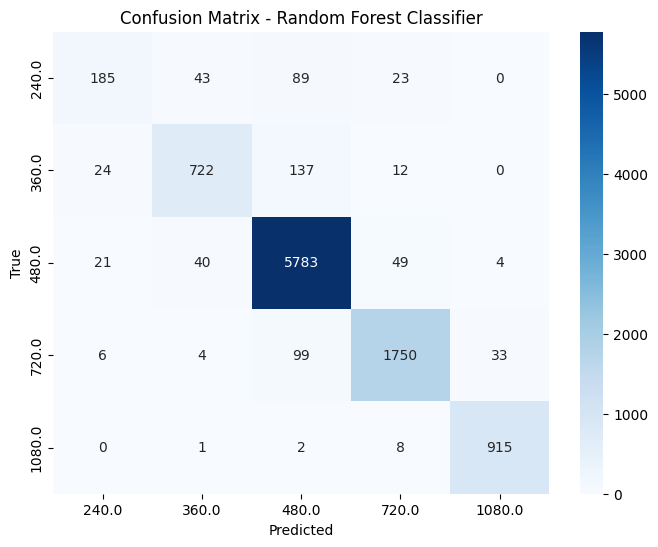

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# --- Initialize the Random Forest model ---
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees grow until all leaves are pure
    min_samples_split=2,    # minimum samples to split a node
    random_state=42,
    n_jobs=-1               # use all CPU cores for speed
)

# --- Train the model ---
rf_model.fit(X_train_scaled, y_train)

# --- Make predictions ---
y_pred = rf_model.predict(X_test_scaled)

# --- Evaluate performance ---
print("✅ Model Evaluation Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Confusion matrix to visualize misclassifications
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [46]:
from sklearn.model_selection import GridSearchCV

# --- Define the parameter grid ---
param_grid = {
    'n_estimators': [100, 200, 300],      # number of trees
    'max_depth': [None, 10, 20, 30],      # tree depth (None = unlimited)
    'min_samples_split': [2, 5, 10],      # min samples to split a node
    'min_samples_leaf': [1, 2, 4],        # min samples per leaf
    'max_features': ['sqrt', 'log2']      # number of features to consider at each split
}

# --- Initialize model ---
rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)

# --- Set up grid search with cross-validation ---
grid_search = GridSearchCV(
    estimator=rf_tuned,
    param_grid=param_grid,
    scoring='f1_macro',        # use F1 macro for balanced class performance
    cv=3,                      # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# --- Fit on training data ---
grid_search.fit(X_train_scaled, y_train)

# --- Best model and parameters ---
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (cross-validated):", grid_search.best_score_)

# --- Replace model with best estimator ---
best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score (cross-validated): 0.8686816230621556


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

✅ Tuned Random Forest Evaluation:
Accuracy: 0.94
F1 Score (macro): 0.8733541625273439

Classification Report:
               precision    recall  f1-score   support

       240.0       0.80      0.54      0.65       340
       360.0       0.90      0.81      0.85       895
       480.0       0.95      0.98      0.96      5897
       720.0       0.95      0.92      0.93      1892
      1080.0       0.96      0.99      0.97       926

    accuracy                           0.94      9950
   macro avg       0.91      0.85      0.87      9950
weighted avg       0.94      0.94      0.94      9950



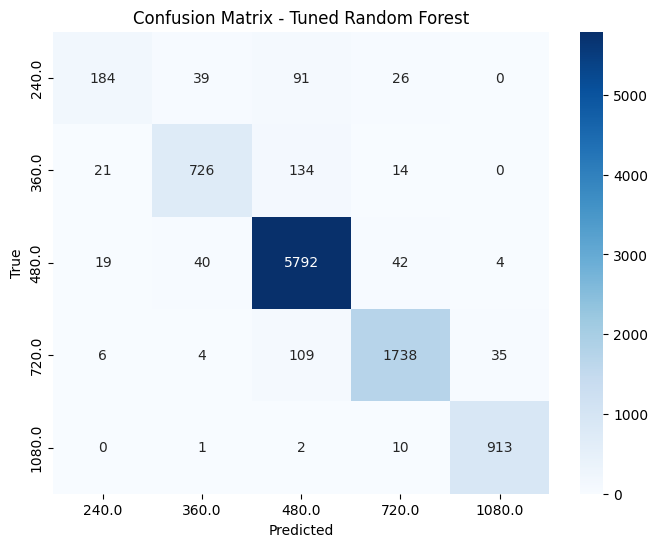

Multiclass ROC-AUC: 0.9126405854009223


In [ ]:
# --- Evaluate tuned model ---
y_pred_best = best_rf.predict(X_test_scaled)

print("Tuned Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("F1 Score (macro):", f1_score(y_test, y_pred_best, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_bin = label_binarize(y_test, classes=best_rf.classes_)
y_pred_bin = label_binarize(best_rf.predict(X_test_scaled), classes=best_rf.classes_)

auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
print("Multiclass ROC-AUC:", auc)


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [ ]:
pcap = PCAP('netflix.pcap', flow_ptks_thres=2)
pcap.pcap2flows()

# --- Use the 4 richest available feature types ---
feature_types = ['IAT', 'STATS', 'SIZE', 'SAMP_SIZE']

features = []
for f in feature_types:
    pcap.flow2features(f, fft=False, header=False)
    features.append(pcap.features)


session_df = pd.DataFrame(np.hstack(features))
numeric_data = session_df.apply(pd.to_numeric, errors='coerce')
numeric_data = numeric_data.fillna(0)


numeric_data = numeric_data[X.columns]


session_scaled = scaler.transform(numeric_data)
predictions = best_rf.predict(session_scaled)

plt.figure(figsize=(12, 6))
plt.plot(predictions, color='royalblue', marker='o', linestyle='-')
plt.title("Predicted Resolution Over Time (10s intervals)")
plt.xlabel("Time Interval")
plt.ylabel("Predicted Resolution (p)")
plt.grid(True, alpha=0.3)
plt.show()


   count      mean        std       min       25%       50%       75%  \
0  184.0  2.761161  10.947101  0.012745  0.197407  0.771669  1.370850   
1  184.0  3.313254  20.182304  0.000000  0.000339  0.031818  1.001306   
2  184.0  3.392416  20.127582  0.000000  0.030202  0.180251  1.102105   
3  184.0  1.629804   9.066103  0.000000  0.001085  0.017764  0.255669   
4  184.0  1.734085   8.744467  0.000000  0.001342  0.013209  1.360998   
5  184.0  2.491350  12.535050  0.000000  0.001584  0.030671  0.965625   
6  184.0  2.908259  10.167342  0.000000  0.001799  0.156922  0.924981   
7  184.0  1.753799   5.655639  0.000000  0.000474  0.002616  0.388385   
8  184.0  3.199684  11.882037  0.000000  0.000000  0.001518  0.568785   
9  184.0  1.481168   8.352277  0.000000  0.000000  0.001268  0.060607   

          max  
0   97.281163  
1  257.357116  
2  254.263998  
3  102.196029  
4   98.099770  
5  133.735207  
6   97.083108  
7   49.910172  
8   97.895262  
9   96.657868  


KeyError: "None of [Index(['10_avg_chunksize', '10_max_chunksize', '10_min_chunksize',\n       '10_std_chunksize', 'all_prev_down_chunk_iat_avg',\n       'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min',\n       'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_avg',\n       'all_prev_up_chunk_iat_max', 'all_prev_up_chunk_iat_min',\n       'all_prev_up_chunk_iat_std', 'bitrate', 'bitrate_change',\n       'c_bitrate_switches', 'c_rebufferings', 'c_resolution_switches',\n       'cumsum_chunksizes', 'down_chunk_iat_avg', 'down_chunk_iat_max',\n       'down_chunk_iat_min', 'down_chunk_iat_std', 'n_bitrate_switches',\n       'n_rebufferings', 'service_Video_throughput_down',\n       'service_Video_throughput_up', 'service_non_video_throughput_down',\n       'service_non_video_throughput_up', 'startup_time',\n       'total_throughput_down', 'total_throughput_up', 'up_chunk_iat_avg',\n       'up_chunk_iat_max', 'up_chunk_iat_min', 'up_chunk_iat_std',\n       'serverAvgBytesInFlight', 'serverBitrateChange',\n       'serverMaxBytesInFlight', 'serverMinBytesInFlight',\n       'serverStdBytesInFlight', 'serverThroughput', 'userAvgBytesInFlight',\n       'userAvgRTT', 'userEndBytesInFlight', 'userMaxBytesInFlight',\n       'userMaxRTT', 'userMinBytesInFlight', 'userMinRTT',\n       'userStdBytesInFlight', 'userStdRTT', 'userStrBytesInFlight',\n       'startup_mc', '10_EWMA_chunksizes'],\n      dtype='object')] are in the [columns]"